# Matrix Factorisation - Linear

This is the classical collaborative filtering model


In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split

In [3]:
%matplotlib inline

### Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [6]:
DATA.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [7]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [8]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [9]:
# Data Splitting
#train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
train, test = random_split(DATA, [0.8, 0.2])

In [10]:
train.shape, test.shape

((80000, 7), (20000, 7))

## Explicit Matrix Factorisation 

This is a model with User and Item Embedding Dot Product

In [11]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from reco import vis

Using TensorFlow backend.


### Build the Model

In [13]:
def ExplicitMF (n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemsE')(item_embedding)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUsersE')(user_embedding)

    # Dot Product of Item and User
    rating = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    
    # Model Creation
    model = Model([user_input, item_input], rating)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [15]:
n_factors = 40
model = ExplicitMF(n_users, n_items, n_factors)

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 40)        67280       Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 40)        37720       User[0][0]                       
____________________________________________________________________________________________

In [17]:
from reco.utils import create_directory
create_directory("/model-img")

Directory already exists /Users/amitkaps/Documents/github/recommendation/MovieLens/model-img


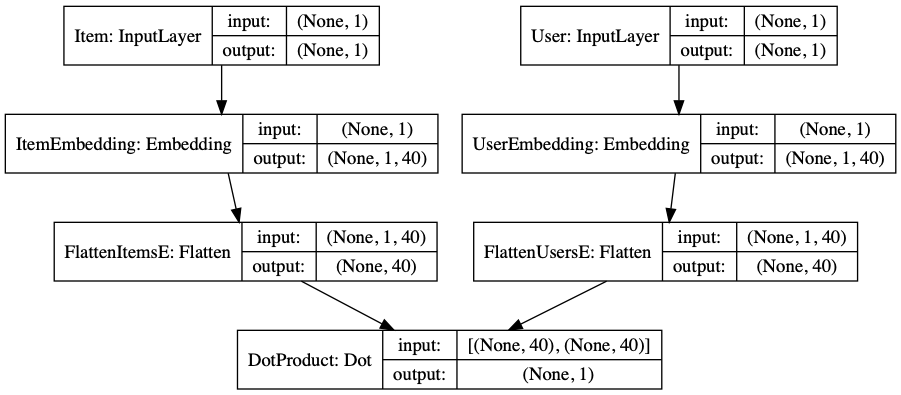

In [18]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/explicit-mf.png" )

### Train the Model

In [19]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, validation_split=0.2)



Train on 64000 samples, validate on 16000 samples
Epoch 1/5
64000/64000 [==============================] - 2s 34us/step - loss: 12.8264 - val_loss: 9.7217
Epoch 2/5
64000/64000 [==============================] - 2s 24us/step - loss: 3.4890 - val_loss: 3.2999
Epoch 3/5
64000/64000 [==============================] - 2s 28us/step - loss: 1.2951 - val_loss: 2.4958
Epoch 4/5
64000/64000 [==============================] - 2s 31us/step - loss: 1.0318 - val_loss: 2.2307
Epoch 5/5
64000/64000 [==============================] - 2s 31us/step - loss: 0.9494 - val_loss: 2.1087
CPU times: user 13.6 s, sys: 1.17 s, total: 14.8 s
Wall time: 10 s


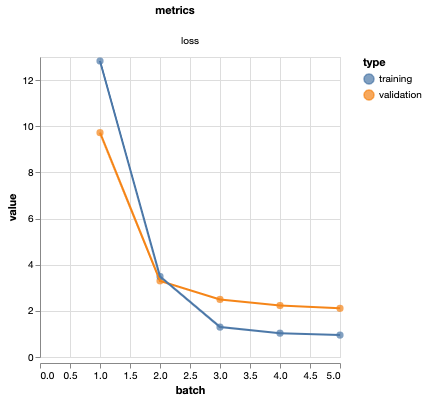

In [20]:
vis.metrics(output.history)

### Score the Model

In [17]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

20000/20000 [==============================] - 1s 26us/step


2.6304835907936095

### Evaluate the Model

In [18]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [19]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [20]:
%%time
predictions = get_predictions(model, DATA)

CPU times: user 34.3 s, sys: 3.2 s, total: 37.5 s
Wall time: 30.4 s


In [21]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,4.294676
1,195,301,4.289435
2,195,376,1.806611
3,195,50,3.525847
4,195,345,3.961609


In [22]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

CPU times: user 37.8 s, sys: 3.65 s, total: 41.4 s
Wall time: 34.3 s


In [23]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.045335
Precision@K:	0.031931
Recall@K:	0.022146


### Get Similar Items

In [24]:
from reco.recommend import get_similar, show_similar

In [25]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: user 135 ms, sys: 3.72 ms, total: 139 ms
Wall time: 140 ms


In [26]:
item_similar_indices

array([[   0,  123,  202,  734,   27],
       [   1,   37,  808,  779, 1167],
       [   2,   37,   16, 1134,  551],
       ...,
       [1679, 1593, 1671, 1555, 1647],
       [1680, 1593, 1677, 1673, 1637],
       [1681, 1624, 1673, 1593, 1576]])

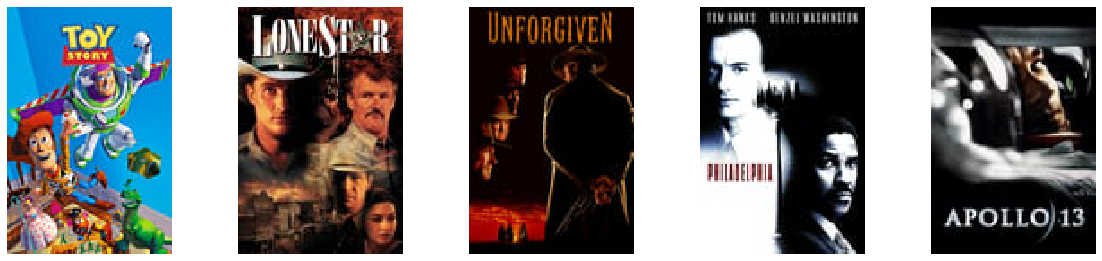

In [27]:
show_similar(0, item_similar_indices, item_encoder)